In [1]:
import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
import sys
import pandas as pd
import pickle
import numpy as np
from tqdm import tqdm
from datetime import datetime
import copy
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [3]:
import platform; print(platform.platform())

macOS-14.6-arm64-arm-64bit


In [4]:
df = pd.read_csv('/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/labelled_data_500.csv')

In [5]:
 x = pd.to_datetime(df['date']).value_counts()

In [6]:
x.sort_index() .index

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-15', '2021-06-16', '2021-06-17',
               '2021-06-18', '2021-06-21', '2021-06-22'],
              dtype='datetime64[ns]', name='date', freq=None)

In [7]:
train_set = df[pd.to_datetime(df['date']) <= pd.to_datetime('2021-06-07')]
test_data = df[pd.to_datetime(df['date']) == pd.to_datetime('2021-06-08')]

In [8]:
train_set.head()

,date,SP1,SV1,BP1,BV1,SP2,SV2,BP2,BV2,SP3,...,BV3,SP4,SV4,BP4,BV4,SP5,SV5,BP5,BV5,label
0,2021-06-01,10200.0,3294,10150.0,61,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,1
1,2021-06-01,10200.0,3294,10150.0,59,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,1
2,2021-06-01,10200.0,3324,10150.0,59,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,1
3,2021-06-01,10200.0,3324,10150.0,43,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,1
4,2021-06-01,10200.0,3324,10150.0,43,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,687,1


In [9]:
train_data =  train_set.iloc[:int(np.floor(train_set.shape[0] * 0.8)),:]
eval_data = train_set.iloc[int(np.floor(train_set.shape[0] * 0.8)):,:]

In [10]:
print(train_data.shape)
train_data.head()

(1732770, 22)


,date,SP1,SV1,BP1,BV1,SP2,SV2,BP2,BV2,SP3,...,BV3,SP4,SV4,BP4,BV4,SP5,SV5,BP5,BV5,label
0,2021-06-01,10200.0,3294,10150.0,61,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,1
1,2021-06-01,10200.0,3294,10150.0,59,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,1
2,2021-06-01,10200.0,3324,10150.0,59,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,1
3,2021-06-01,10200.0,3324,10150.0,43,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,1
4,2021-06-01,10200.0,3324,10150.0,43,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,687,1


In [11]:
def normalize_data(df,cols,norm):
    #Normalizing using z-score
    if norm=='Z':
        scaler = StandardScaler()
        scaler.fit(df[cols])
        data = scaler.transform(df[cols])
    
    
    #Normalizing using DecPrec
    if norm=='DecPrec':
        k_len = np.ceil(np.log10(df[cols].abs().max()))
        # print(k_len)
        data = df[cols]/(10**k_len)

    return data,scaler

In [12]:
train_input , scaler = normalize_data(train_data.iloc[:,1:-1],train_data.iloc[:,1:-1].columns,'Z')

In [13]:
train_input.shape

(1732770, 20)

In [14]:
train_label = train_data.iloc[:,-1].to_numpy()
eval_input = scaler.transform(eval_data.iloc[:,1:-1])
eval_label = eval_data.iloc[:,-1].to_numpy()
test_input = scaler.transform(test_data.iloc[:,1:-1])
test_label = test_data.iloc[:,-1].to_numpy()

In [15]:
del train_set

In [16]:
del [train_data,test_data,eval_data,df]

In [17]:
np.isnan(eval_input).any()

False

In [18]:
class Dataset_LOB(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x,y, num_classes, T):
        """Initialization""" 
        # self.k = k
        self.num_classes = num_classes
        self.T = T
            
        # x = prepare_x(data)
        # y = get_label(data)
        x, y = data_classification(x, y, self.T)
        # y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [19]:
def data_classification(X, Y, T):
    [N, D] = X.shape
    # print(X.shape,T,N,Y.shape)
    df = np.array(X)
    # print(df.shape)
    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY


In [20]:
batch_size = 64
dataset_train = Dataset_LOB(train_input,train_label, num_classes=3, T=100)
dataset_eval = Dataset_LOB(eval_input,eval_label, num_classes=3, T=100)
dataset_test = Dataset_LOB(test_input,test_label, num_classes=3, T=100)

# test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

In [21]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_eval, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

In [22]:
print(dataset_train.x.shape, dataset_test.y.shape)

torch.Size([1732671, 1, 100, 20]) torch.Size([282495])


In [24]:
sys.getsizeof(train_input)/1000000

0.000128

In [23]:
# freeing data
# df=None
# train_set = None
# eval_data = None

In [25]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[ 0.9308, -0.9392,  0.8519,  ..., -0.5216,  0.8641, -0.9638],
          [ 0.9308, -0.9419,  0.8519,  ..., -0.5216,  0.8641, -0.9638],
          [ 0.9308, -0.9409,  0.8519,  ..., -0.5216,  0.8641, -0.9638],
          ...,
          [ 0.9308, -0.7869,  0.8519,  ..., -0.5645,  0.8641, -0.9653],
          [ 0.9308, -0.7869,  0.8519,  ..., -0.5645,  0.8641, -0.9653],
          [ 0.9308, -0.7869,  0.8519,  ..., -0.5645,  0.8641, -0.9653]]]],
       dtype=torch.float64)
tensor([1])
torch.Size([1, 1, 100, 20]) torch.Size([1])


In [27]:
# from pympler import asizeof
s=0
for key,obj in locals().items():
    cc= sys.getsizeof(obj)/1000000
    s+=cc
    if cc>20:
        print(key,cc)
print(s,'mb')

0.019377999999999992 mb


In [28]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

device = mps_device

tensor([1.], device='mps:0')


In [25]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,5)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

In [26]:
model = deeplob(y_len = dataset_train.num_classes)
model.to(mps_device)
device = mps_device

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# state_dict = None

In [35]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    global state_dict
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            # state_dict = copy.deepcopy(model.state_dict())
            torch.save(model, '/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/best_val_5level_model_pytorch')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(dt)
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses

In [36]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=10)

 10%|████                                    | 1/10 [41:28<6:13:13, 2488.16s/it]

model saved
0:41:28.154958
Epoch 1/10, Train Loss: 0.6752,           Validation Loss: 0.7554, Duration: 0:41:28.154958, Best Val Epoch: 0


 20%|███████▌                              | 2/10 [2:12:04<9:22:59, 4222.38s/it]

1:30:36.317609
Epoch 2/10, Train Loss: 0.6737,           Validation Loss: 0.7554, Duration: 1:30:36.317609, Best Val Epoch: 0


 30%|███████████▍                          | 3/10 [2:41:33<6:01:53, 3101.91s/it]

0:29:28.526023
Epoch 3/10, Train Loss: 0.6737,           Validation Loss: 0.7554, Duration: 0:29:28.526023, Best Val Epoch: 0


 40%|███████████████▏                      | 4/10 [3:12:22<4:20:43, 2607.32s/it]

0:30:49.079999
Epoch 4/10, Train Loss: 0.6737,           Validation Loss: 0.7554, Duration: 0:30:49.079999, Best Val Epoch: 0


 50%|███████████████████                   | 5/10 [3:43:17<3:14:40, 2336.10s/it]

0:30:55.190691
Epoch 5/10, Train Loss: 0.6737,           Validation Loss: 0.7554, Duration: 0:30:55.190691, Best Val Epoch: 0


 60%|██████████████████████▊               | 6/10 [4:14:13<2:24:52, 2173.03s/it]

0:30:56.468726
Epoch 6/10, Train Loss: 0.6737,           Validation Loss: 0.7554, Duration: 0:30:56.468726, Best Val Epoch: 0


 70%|██████████████████████████▌           | 7/10 [4:45:20<1:43:39, 2073.02s/it]

0:31:07.114210
Epoch 7/10, Train Loss: 0.6737,           Validation Loss: 0.7554, Duration: 0:31:07.114210, Best Val Epoch: 0


 80%|██████████████████████████████▍       | 8/10 [5:16:25<1:06:53, 2006.60s/it]

0:31:04.358482
Epoch 8/10, Train Loss: 0.6737,           Validation Loss: 0.7554, Duration: 0:31:04.358482, Best Val Epoch: 0


 90%|████████████████████████████████████    | 9/10 [5:47:22<32:40, 1960.01s/it]

0:30:57.542389
Epoch 9/10, Train Loss: 0.6737,           Validation Loss: 0.7554, Duration: 0:30:57.542389, Best Val Epoch: 0


100%|███████████████████████████████████████| 10/10 [6:18:23<00:00, 2270.35s/it]

0:31:00.542859
Epoch 10/10, Train Loss: 0.6737,           Validation Loss: 0.7554, Duration: 0:31:00.542859, Best Val Epoch: 0


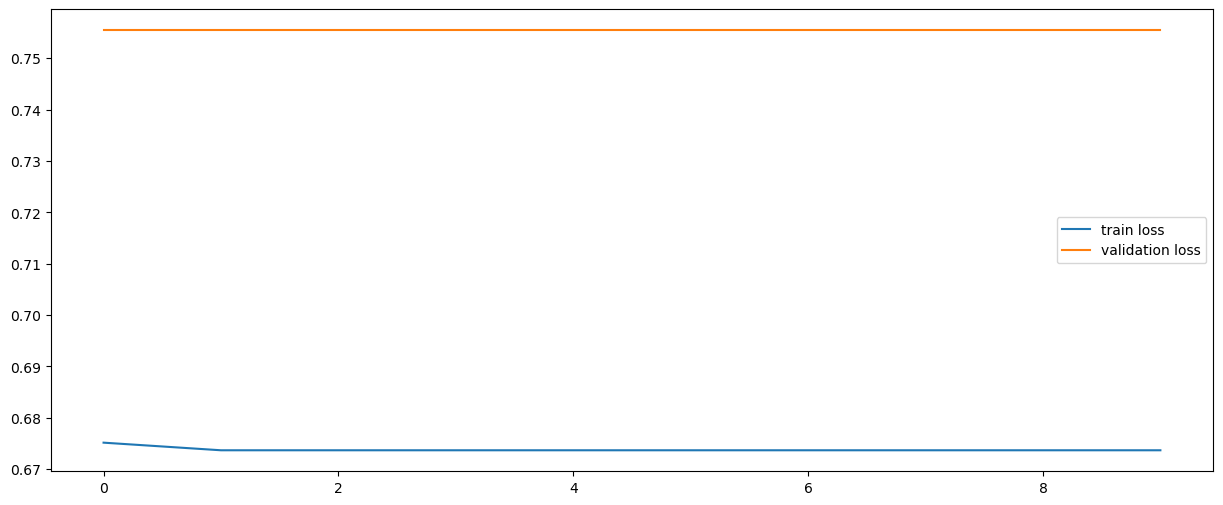

In [39]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

## Model_Testing

In [40]:
n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.8505


In [41]:
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)  

In [42]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.8505354077063311
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     22858
           1     0.8505    1.0000    0.9192    240272
           2     0.0000    0.0000    0.0000     19365

    accuracy                         0.8505    282495
   macro avg     0.2835    0.3333    0.3064    282495
weighted avg     0.7234    0.8505    0.7818    282495



/opt/anaconda3/envs/dawai/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dawai/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dawai/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
model = deeplob(y_len = dataset_train.num_classes)
model = torch.load('/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/best_val_5level_model_pytorch')
model.to(mps_device)
model.eval()

/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_29737/3214504261.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/Users/jandh/Desktop/Old 

deeplob(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride

In [28]:
# model = torch.load('best_val_model_pytorch')
all_targets = []
all_predictions = []

for inputs, targets in train_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions) 

In [29]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.8777667543347814


/opt/anaconda3/envs/dawai/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dawai/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000    110877
           1     0.8778    1.0000    0.9349   1520881
           2     0.0000    0.0000    0.0000    100913

    accuracy                         0.8778   1732671
   macro avg     0.2926    0.3333    0.3116   1732671
weighted avg     0.7705    0.8778    0.8206   1732671



/opt/anaconda3/envs/dawai/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
